# Example to calculate photon-ALP oscillations from NGC 1275 in a cavity field

This notebook demonstrates how to calculate the photon-ALP transition probability for NGC 1275, the central AGN of the Perseus cluster. The assumed B-field environments are the same as in https://arxiv.org/abs/1908.03084, and include the cluster field and the magnetic field of the Milky Way. Electron density model parameters taken from https://iopscience.iop.org/article/10.1086/374923/fulltext/57155.text.html.

Note that in order to obtain the field used in 1908.03084, you have to set $\theta$ to 225° instead of 45° (adding 180°). This effectively inverts the sign of all field components. While this change of $\theta$ and the sign is irrelevant for the conversion probability, it changes the field along the line of sight and inverts the sign of the RM, as well.

In [1]:
from github.galps.gammaALPs.core import Source, ALP, ModuleList
from github.galps.gammaALPs.base import environs, transfer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
from ebltable.tau_from_model import OptDepth
from astropy import constants as c

In [3]:
%matplotlib inline

### Set the ALP

Initialize an ALP object, that stores the ALP mass $m$ (in neV) and the coupling $g$ (in $10^{-11}\mathrm{GeV}^{-1}$).

In [4]:
m, g = 2, 100
alp = ALP(m,g)

## Set the source

Set the source properties (redshift and sky coordinates) in the ```Source``` containier

In [12]:
ngc1275 = Source(z = 0.017559, ra = '03h19m48.1s', dec = '+41d30m42s')

### Init the module list

Initialize the list of transfer modules that will store the different magnetic field environments. 

Energies are supplied in GeV as ```numpy.ndarray```

In [3]:
logEMeV = np.loadtxt('energy_bins.dat')
EGeV = np.power(10, logEMeV - 3.)

Now initialize the initial photon polarization. Since we are dealing with a gamma-ray source, no ALPs are initially present in the beam (third diagonal element is zero). The polarization density matrix is normalized such that its trace is equal to one, $\mathrm{Tr}(\rho_\mathrm{in}) = 1$.

In [4]:
pin = np.diag((1.,1.,0.)) * 0.5

### Add modules:

Now we add propagation modules for the cluster, the EBL, and the Galactic magnetic field; run the module. Repeat for only the ICM field.

In [11]:

for c, g in enumerate([1e2, 6e1, 3e1, 1e1]):
    alp = ALP(m, g)
    pgg = np.loadtxt(f'/mnt/5012B5DF12B5C9EC/master_thesis/fermilat/NGC_1275/ts_limit/structured_field/pgg_struc_{c}.dat')
    ml = ModuleList(alp, ngc1275, pin = pin, EGeV = EGeV)
    ml.add_propagation("ICMStructured", 
                       0, # position of module counted from the source. 
                       B0 = 8.3,  # rms of B field
                       R = 93,
                       theta = 225,
                       theta_rad=False,
                       pa=147,
                       pa_rad=False,
                       n0 = 39e-2,  # normalization of electron density
                       n2 = 4.05e-3, # second normalization of electron density, see Churazov et al. 2003, Eq. 4
                       r_abell = 500., # extension of the cluster
                       r_core = 80.,   # electron density parameter, see Churazov et al. 2003, Eq. 4
                       r_core2 = 280., # electron density parameter, see Churazov et al. 2003, Eq. 4
                       beta = 1.2,  # electron density parameter, see Churazov et al. 2003, Eq. 4
                       beta2= 0.58, # electron density parameter, see Churazov et al. 2003, Eq. 4
                       eta = 0 # scaling of B-field with electron denstiy
                       )
    ml.add_propagation("EBL",1, eblmodel = 'dominguez') # EBL attenuation comes second, after beam has left cluster
    ml.add_propagation("GMF",2, model = 'pshirkov', model_sym = 'BSS') # finally, the beam enters the Milky Way Field

    px, py, pa = ml.run()
    psurv = px+py
    print(np.any(np.isclose(psurv[0], pgg)))

    '''
    # again with only structured field

    ml2 = ModuleList(alp, ngc1275, pin = pin, EGeV = EGeV)
    ml2.add_propagation("ICMStructured", 
                       0, # position of module counted from the source. 
                       B0 = 8.3,  # rms of B field
                       R = 93,
                       theta = 225,
                       theta_rad=False,
                       pa=147,
                       pa_rad=False,
                       n0 = 39.,  # normalization of electron density
                       n2 = 4.05, # second normalization of electron density, see Churazov et al. 2003, Eq. 4
                       r_abell = 500., # extension of the cluster
                       r_core = 80.,   # electron density parameter, see Churazov et al. 2003, Eq. 4
                       r_core2 = 280., # electron density parameter, see Churazov et al. 2003, Eq. 4
                       beta = 1.2,  # electron density parameter, see Churazov et al. 2003, Eq. 4
                       beta2= 0.58, # electron density parameter, see Churazov et al. 2003, Eq. 4
                       eta = 0 # scaling of B-field with electron denstiy
                       )
    px2, py2, pa2 = ml2.run()
    '''


NameError: name 'ngc1275' is not defined

List the module names:

## Plot the output 

font_manager.py:1355 --- WARNING: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


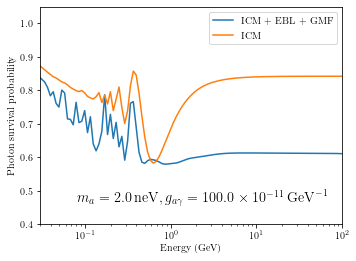

In [8]:
plt.plot(EGeV, px[0] + py[0], label='ICM + EBL + GMF')
plt.plot(EGeV, px2[0] + py2[0], label='ICM')
plt.xscale('log')
plt.yscale('linear')
plt.ylim(0.4, 1.05)
plt.xlim(3e-2, 1e2)
plt.xlabel('Energy (GeV)')
plt.ylabel('Photon survival probability')
plt.legend(loc = 0, fontsize = 'medium')

plt.annotate(r'$m_a = {0:.1f}\,\mathrm{{neV}}, g_{{a\gamma}} = {1:.1f} \times 10^{{-11}}\,\mathrm{{GeV}}^{{-1}}$'.format(ml.alp.m,ml.alp.g),
             xy = (0.95,0.1), size = 'x-large', xycoords = 'axes fraction', ha = 'right')

plt.subplots_adjust(left = 0.2)
#plt.savefig("pgg.png", dpi = 150)

# Plot the B fields

Plot r vs B field components of structured field, also plot electron density

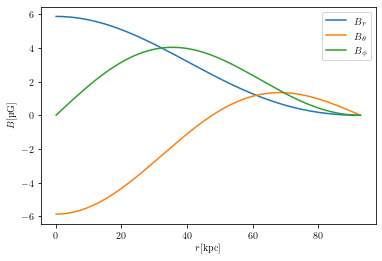

In [18]:
r = ml.modules[0].r
b_r = ml.modules[0]._Bfield_model.b_r
b_theta = ml.modules[0]._Bfield_model.b_theta
b_phi = ml.modules[0]._Bfield_model.b_phi
plt.plot(r, b_r, label='$B_r$')
plt.plot(r, b_theta, label=r'$B_\theta$')
plt.plot(r, b_phi, label=r'$B_\phi$')
plt.xlabel(r'$r [\SI{}{\kilo\parsec}]$')
plt.ylabel(r'$B [\SI{}{\micro\gauss}]$')
plt.legend()

Text(0.5, 0, '$r$ (kpc)')

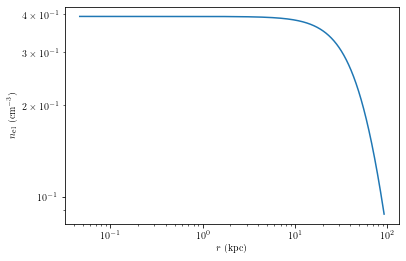

In [20]:
nel = ml.modules[0]._nelicm(r)   # in cm^-3
plt.plot(r, nel)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('$n_\mathrm{el}$ (cm$^{-3}$)')
plt.xlabel('$r$ (kpc)')

# Calculate rotation measure

Faraday RM can be calculated via a method of the structured field model, arguments areelectron density evaluated at r = structured_field.r in cm^-3 and eta (scaling exponent of B with electron density)

In [11]:
ml.modules[0]._Bfield_model.rotation_measure(nel)   # in rad * m^-2

7309.7713888988355

Taylor et al. (2006) found RM values between 6500 and 7500 rad m^-2

   core.py: 652 --- INFO: Running Module 0: <class 'github.galps.gammaALPs.base.environs.MixICMStructured'>


3.9269908169872414
You need to manually set dL_vec!


   core.py: 652 --- INFO: Running Module 0: <class 'github.galps.gammaALPs.base.environs.MixICMStructured'>


True
3.9269908169872414
You need to manually set dL_vec!


   core.py: 652 --- INFO: Running Module 0: <class 'github.galps.gammaALPs.base.environs.MixICMStructured'>


True
3.9269908169872414
You need to manually set dL_vec!


   core.py: 652 --- INFO: Running Module 0: <class 'github.galps.gammaALPs.base.environs.MixICMStructured'>


True
3.9269908169872414
You need to manually set dL_vec!
True


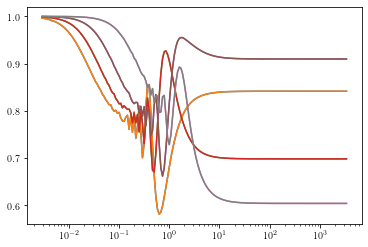

In [23]:

m = 2
b0=8.3
pin = np.diag((1, 1, 0)) * 0.5


source = Source(z = 0.017559, ra = '03h19m48.1s', dec = '+41d30m42s')
for c, g in enumerate([1e2, 6e1, 3e1, 1e1]):
    pgg = np.loadtxt(f'/mnt/5012B5DF12B5C9EC/master_thesis/fermilat/NGC_1275/ts_limit/structured_field/pgg_struc_{c}_from_array.dat')
    alp = ALP(m,g)
    ml = ModuleList(alp, source, pin=pin, EGeV=EGeV)
    ml.add_propagation("ICMStructured", 
                       0, # position of module counted from the source. 
                       B0 = 8.3,  # rms of B field
                       R = 93,
                       theta = 225,
                       theta_rad=False,
                       pa=147,
                       cell_num=1000,
                       pa_rad=False,
                       n0 = 3.9e-2,  # normalization of electron density
                       n2 = 4.05e-3, # second normalization of electron density, see Churazov et al. 2003, Eq. 4
                       r_abell = 500., # extension of the cluster
                       r_core = 80.,   # electron density parameter, see Churazov et al. 2003, Eq. 4
                       r_core2 = 280., # electron density parameter, see Churazov et al. 2003, Eq. 4
                       beta = 1.2,  # electron density parameter, see Churazov et al. 2003, Eq. 4
                       beta2= 0.58, # electron density parameter, see Churazov et al. 2003, Eq. 4
                       eta = 0 # scaling of B-field with electron denstiy
                       )
    #ml.add_propagation("EBL",1, eblmodel='dominguez')
    #ml.add_propagation("GMF",2, model='pshirkov', model_sym='BSS')
    px, py, pa = ml.run()
    psurv = px + py
    print(np.all(np.isclose(psurv[0], pgg)))
    plt.plot(EGeV, psurv[0], label='new module')
    plt.plot(EGeV, pgg, label='from array')
plt.xscale('log')